In [24]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf

tf.get_logger().setLevel('ERROR')

warp_blur_min=np.array([2, 4, 8])
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2

# en=[16,32,64,64,64,64,64]
# de=[64,64,64,64,64,32,16,2]

# en=[16,16, 32,32, 64,64,128,128, 256,256]
# de=[256,256, 128,128,64,64,32,32,16,16,2]

# en=[16,16, 32,32, 64,64, 64,64, 64, 64,64, 64,64, 64]
# de=[64,64, 64,64, 64, 64,64, 64,64, 64,32,32,16,16,2]

# en=[128,128,128,128,128]
# de=[128,128,128,128,128,2]

# nb_features = '_'.join(map(str, en))
# log_dir='logs_feta'
# models_dir='models_feta_mom_brain_params_'+str(nb_features)+"_nc_2_bs_1"
# print(models_dir)
# initial_epoch=240
# checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

# num_labels=8
# data_dir = 'feta_2d/'

# feta = pathlib.Path('feta_scaled_3')
# feta_files = list(feta.glob('*.nii.gz'))
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]

# # feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_2d')
# # files = list(feta.glob('sub-???/sub-???_dseg.nii.gz'))
# # label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]
# labels = np.unique(feta_label_maps)

# mgh = pathlib.Path('fetus_label_map')
# mgh_files = list(mgh.glob('*.nii.gz'))
# label_maps = [np.uint8(sf.load_volume(str(file_path)).data) for file_path in mgh_files]
# labels_in = np.unique(label_maps)
# in_shape = label_maps[0].shape


# labels = np.unique(label_maps)

# labels_in = range(max(labels) + num_labels + 1)
#
# print(labels_in)
import numpy as np



random.seed(3000)

def load_model3D(checkpoint_path,num_dim=2,nb_labels=2,
                                            dimx=256,
                                            dimy=256,
                                            dimz=256,
                                            nb_features=64,
                                            batch_size=8,
                                            warp_max=2.5,
                                            warp_min=.5,
                                            warp_blur_min=np.array([2, 4, 8]),
                                            warp_blur_max=warp_blur_min*2,
                                            bias_blur_min=np.array([2, 4, 8]),
                                            bias_blur_max=bias_blur_min*2,
                                            initial_lr=1e-4,
                                            lr = 1e-4,
                                            lr_lin = 1e-4,
                                            nb_levels=5,
                                            conv_size=3,
                                            num_epochs=40000,
                                            num_bg_labels=16,
                                            nb_conv_per_level=2):
    input_img = Input(shape=(dimx, dimy, dimz, 1))
    
    unet_model = vxm.networks.Unet(inshape=(dimx, dimy, dimz, 1), nb_features=(en, de), 
                                   nb_conv_per_level=nb_conv_per_level,
                                   final_activation_function='softmax')

    segmentation = unet_model(input_img)
    combined_model = Model(inputs=input_img, outputs=segmentation)

    if os.path.exists(checkpoint_path):
        combined_model.load_weights(checkpoint_path)
        print("Loaded weights from the checkpoint and continued training.")
    else:
        # print(checkpoint_path)
        print("Checkpoint file not found.")
    unet_model = combined_model.layers[-1]

    return unet_model


num_row = 3
per_row = 10

# def process_image(im,unet_model):
#     im = tf.expand_dims(im, axis=0)  # Adding a batch dimension at axis 0
#     im = tf.expand_dims(im, axis=-1)  # Adding another dimension at the end (assuming it's a single-channel image)

#     predictions = unet_model.predict(im, verbose=0)
#     predictions_argmax = np.argmax(predictions, axis=-1)
#     return predictions_argmax

    
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.sum(np.logical_and(ground_truth, predicted))
    union = np.sum(np.logical_or(ground_truth, predicted))

    dice_coefficient = (2.0 * intersection) / (union + intersection)
    return dice_coefficient

def print_row_dice_coefficients(i, row_dice_coefficients):
    formatted_dice = [f"   {dice:.4f}" for j, dice in enumerate(row_dice_coefficients)]
    num_spaces = num_row-1
    padding_left = 0
    padding_right = 0

    formatted_output = f"{' ' * padding_left}{'       '.join(formatted_dice)}{' ' * padding_right}"
    print(f' {formatted_output}')
    

# log_dir='logs_feta'
initial_epoch=110
en=[16,16, 32,32, 64,64,128,128, 256,256]
de=[256,256, 128,128,64,64,32,32,16,16,2]

nb_features = '_'.join(map(str, en))
dim_=256
# sc=0.1
# zb=0.2
# models_dir='models_fov_1mm_mom_brain_params_dim_'+str(dim_)+'_'+str(nb_features)+"_nc_2_bs_1_sc_"+str(sc)+'_zb_'+str(zb)
# models_dir='models_feta_fov_body_gmm_mom_brain_params_dim_'+str(dim_)+'_'+str(nb_features)
# models_dir='models_mgh_brain_mgh_body'
models_dir='models_feta_mgh_body'
# models_dir='models_shapes_feta_lr_1e-06'

# models_dir='models_feta_mgh_body_params_dim_256_16_16_32_32_64_64_128_128_256_256_wm_0.2_shift_30'
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'
print(checkpoint_path)
combined_model = load_model3D(checkpoint_path,num_dim=3, dimx=dim_,
                                                       dimy=dim_,
                                                       dimz=dim_)
# combined_model.summary()

models_feta_mgh_body/weights_epoch_110.h5
Loaded weights from the checkpoint and continued training.


dim 3 space [1, 2, 3] a.dim (1, 256, 256, 256, 2) b.dim (1, 256, 256, 256, 2)
Soft Dice Coefficient: -0.7845563888549805
Hard Dice Coefficient: 0.47419448056639213


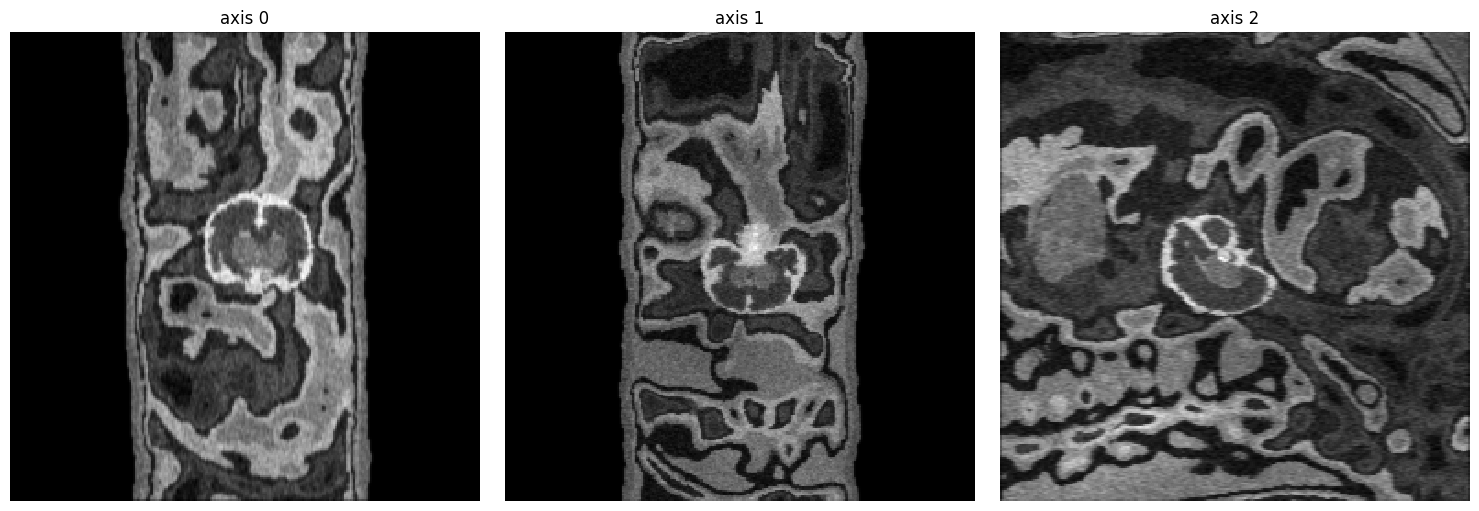

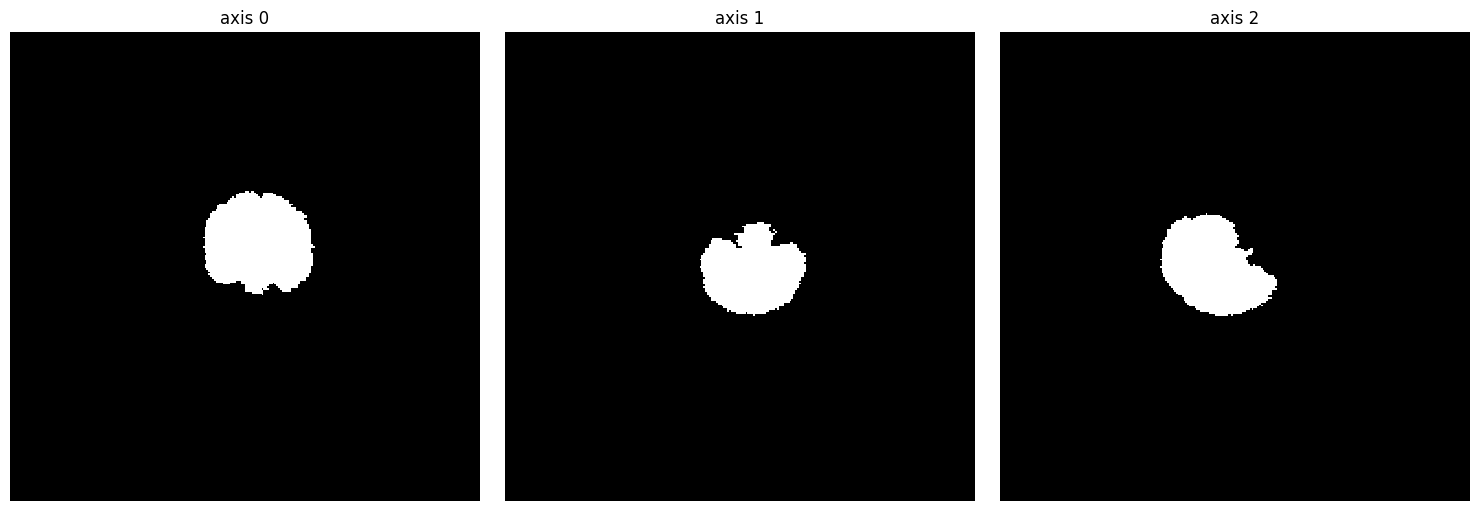

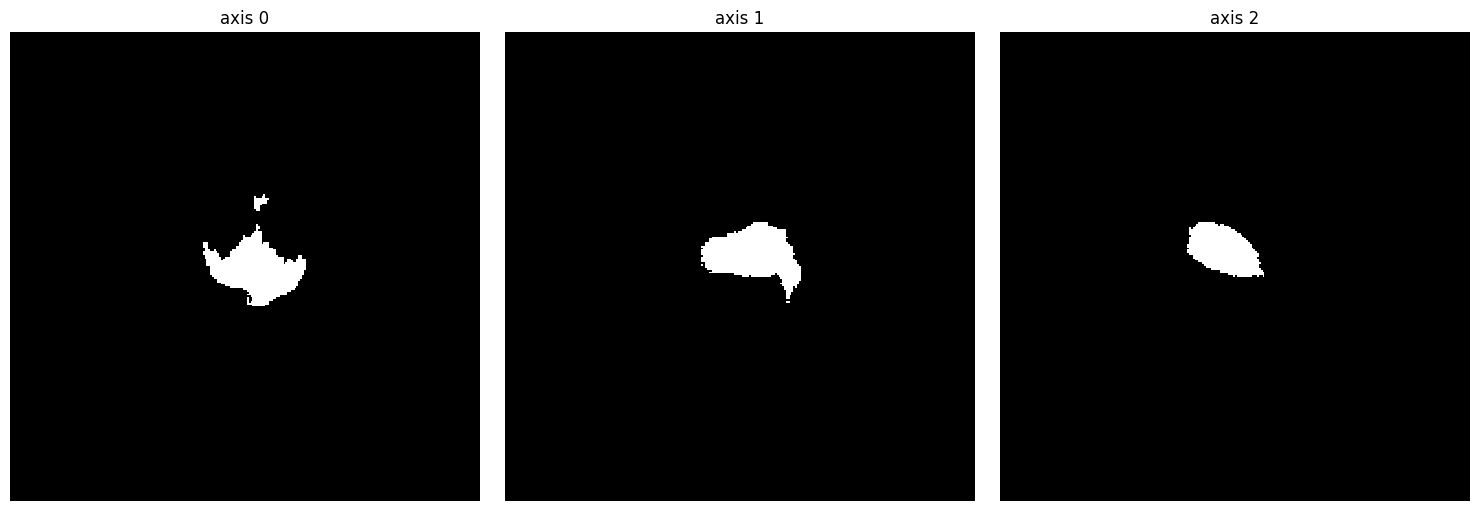

In [25]:
import os
import numpy as np
import surfa as sf
from utils import resize
import re

import numpy as np
from sklearn.metrics import f1_score

def process_image(im, unet_model):
    a = im.copy()
    return unet_model.predict(a[None,...,None], verbose=0)
    
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (union) 

def my_hard_dice(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    dice = dice_coefficient(y_true_flat, y_pred_flat)
    return dice

def soft_dice(a, b):
    dim = len(a.shape) - 2
    space = list(range(1, dim + 1))
    print("dim",dim,"space",space,"a.dim",a.shape,"b.dim",b.shape)
    top = 2 * tf.reduce_sum(a * b, axis=space)
    bot = tf.reduce_sum(a ** 2, axis=space) + tf.reduce_sum(b ** 2, axis=space)
    
    out = tf.divide(top, bot + 1e-6)
    return -tf.reduce_mean(out)


# def my_soft_dice(a, b):
#     dim = a.ndim - 1
#     space = tuple(range(1, dim + 1))
#     top = 2 * np.sum(a * b, axis=space)
#     bot = np.sum(a**2, axis=space) + np.sum(b**2, axis=space)
#     out = top / (bot + 1e-6)
#     return -np.mean(out) 
    
def my_dice_coefficient(y_true, y_pred, smooth=1e-8):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)
    
def minmax_norm(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)

def find_manual_mask(filename):
    base_filename, _ = os.path.splitext(filename)  # Separate filename and extension
    pattern = re.compile(rf"manual_masks_b\d+_mom_\d+_{re.escape(base_filename)}_segment\.nii\.gz")

    matches = [f for f in os.listdir("mgh_2d") if pattern.match(f)]
    
    if matches:
        return matches[0]
dataset = "samples"     # samples
if dataset =="mgh_2d":
    filenames = ['1.mgz','2.mgz','3.mgz','4.mgz']
    filename = filenames[2]
    manual_mask = 'man_'+filename.split(".")[0]+'.nii.gz'
elif dataset=="samples":
    filename="feta_mgh0.nii.gz"
    manual_mask='feta_mask_mgh0.nii.gz'


def save_prediction(image, prediction, output_file_path):
    pred = image.new(prediction)
    # conformed = pred.resample_like(image)
    pred.astype(np.int32).save(output_file_path)
    

image = sf.load_volume(os.path.join(dataset, filename))#.resize()

dim_ = 256

crop_img = image#.resize([1, 1, 1]).reshape((dim_, dim_, dim_,1))
crop_img.save("output/crop_img.mgz")

crop_data = minmax_norm(crop_img.data)

prediction_one_hot = process_image(crop_data, combined_model)
predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
prediction = np.squeeze(predictions_argmax, axis=0)

########### visualize ########
from tensorflow.keras.utils import to_categorical

mask = sf.load_volume(os.path.join(dataset, manual_mask))#.reshape((dim_, dim_, dim_))
prediction = sf.Volume(prediction)#.reshape(mask.data.shape)#.resample_like(mask)

output_file_path = os.path.join('output', 'prediction.nii.gz')
save_prediction(crop_img, prediction, output_file_path)

a = to_categorical(mask.data, num_classes=2)[None,...]
b=prediction_one_hot
dice_score = soft_dice(a, b)
hard_dice_score = my_hard_dice(mask.data, prediction.data)

print(f"Soft Dice Coefficient: {dice_score}")
print(f"Hard Dice Coefficient: {hard_dice_score}")

ne.plot.volume3D(crop_img);
ne.plot.volume3D(mask);
ne.plot.volume3D(prediction);



In [15]:
# a
rand = np.random.default_rng()
idx1 = rand.choice(10)
print(idx1)

9


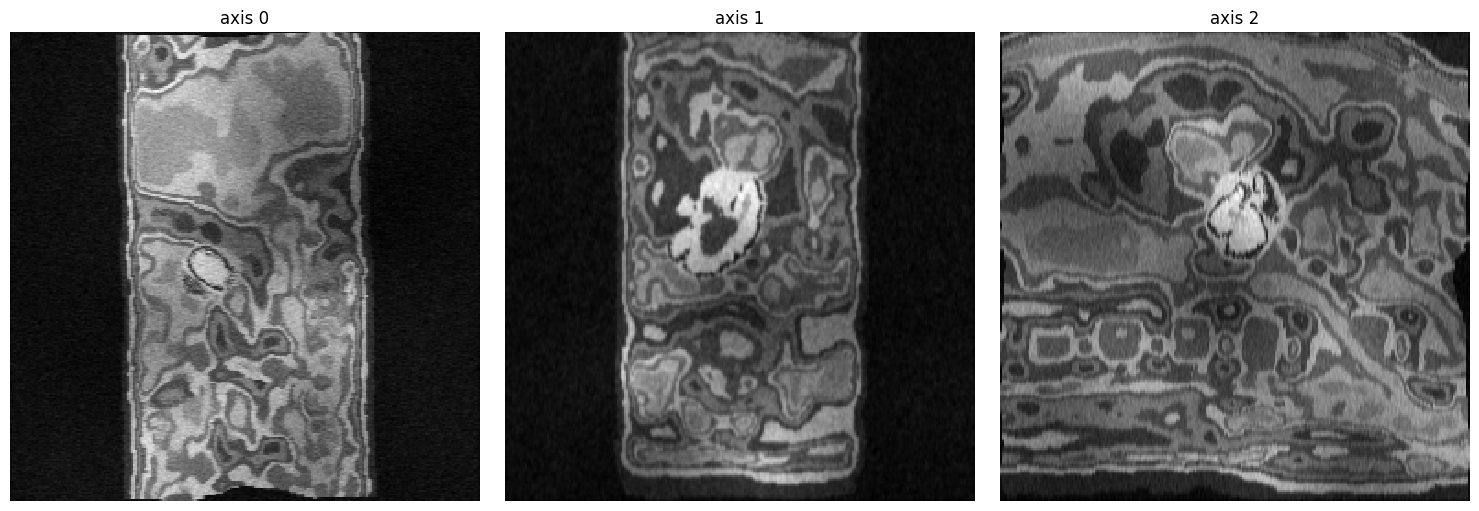

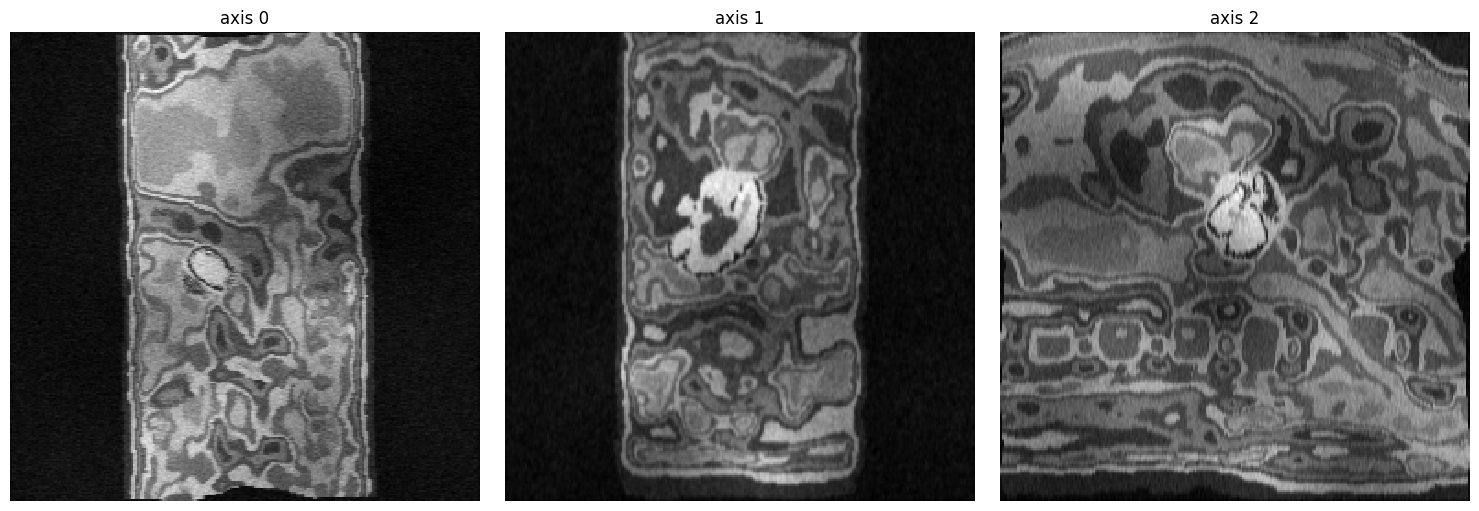

In [24]:
nifti_img = sf.Volume(crop_data)#nib.Nifti1Image(prediction.astype(np.float32), affine=np.eye(4))  # Assuming identity affine for simplicity
nifti_img.geom = image.geom
nifti_img = nifti_img.resample_like(image)

ne.plot.volume3D(image)
ne.plot.volume3D(nifti_img)